# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus_new0','pionminus_new1','pionminus_new2','pionminus_new3','pionminus_new4','pionminus_new5']
filenames2 = ['eccbar']#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500
hadron_weight = 500

In [3]:
if True:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1['phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata['phi0'] = 0
        print(idata.shape[0])
        #idata = idata[:int(idata.shape[0]/6)]
        #print(idata.shape[0])
        data1 = pd.concat([data1,idata], sort=False)

    data2 = pd.read_csv(filepath+f'{filenames2[0]}.csv')
    data2['phi0'] = 1
    for ifile in range(1,len(filenames2)):
        idata = pd.read_csv(filepath+f'{filenames2[ifile]}.csv')
        idata['phi0'] = 1
        data2 = pd.concat([data2,idata], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data[(data['pt'] > 0.4) & (data['pt'] < 25) & (data['n0'] > -1)  ]

    data = data.sample(frac = 1)
    

    data.head()

9310610
9335106
9323331
9330063
9323331


In [4]:
if True:
    data['disp2'] = data['n0']-data['disp2']/4.
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['e/p*pt'] = data['n0']+4*data['pt']
    data['n0*pt'] = 1./((data['e/p']-0.9)*(data['e/p']-0.9)+0.25)/(1.25-data['prob'])+4*data['pt']
if False:
    data['disp2'] = data.apply(lambda row: row['n0']-row['disp']**2, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    #data['e/p*prob'] = data.apply(lambda row:  1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob']), axis=1)
    #data['n0*prob'] = data.apply(lambda row: (row['n0']-2)/(1.00001-row['prob']), axis=1)
    data['centr+pt'] = data.apply(lambda row: row['centrality']/20.+row['pt']*2, axis=1)
    data['e/p*pt'] = data.apply(lambda row: row['n0']+4*row['pt'], axis=1)
    data['n0*pt'] = data.apply(lambda row: 1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob'])+4*row['pt'], axis=1)

In [5]:
if False:
    fliname_loc = 'TreenewDB'
    data = pd.read_csv(filepath+f'{fliname_loc}.csv')

In [6]:
data.head()

centrality        zdc        pt       e/p  n0      disp   chi2/npe0  \
5127151          22  -3.976562  1.075668  1.076842   3  1.439219    1.582806   
9044969          20 -73.187500  0.597833  1.178017   3  1.047585    6.635222   
6086248           2 -33.718750  0.726689  0.397948   1  7.740444  128.048837   
6411744          75 -20.031250  2.234852  0.937985   6  0.922230    2.059950   
2077588           5  14.750000  0.402324  1.083186   2  2.238889   10.168872   

         npe0      prob      disp2  phi0  centr+pt     e/p*pt      n0*pt  
5127151     3  0.388676   2.482163     1  2.257062   7.302673   8.430344  
9044969     5  0.761242   2.725642     1  1.357404   5.391331   8.642602  
6086248     1  0.752877 -13.978617     0  0.628077   3.906756   6.913427  
6411744    14  0.484072   5.787373     1  8.744563  14.939407  14.131863  
2077588     4  0.916722   0.746845     1  0.411864   3.609295  12.190937

In [7]:
print(data.size, data.shape)

160791204 (11485086, 14)


In [8]:
# удалим лишние колонки
data = data.drop(columns = ['zdc'])

In [9]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


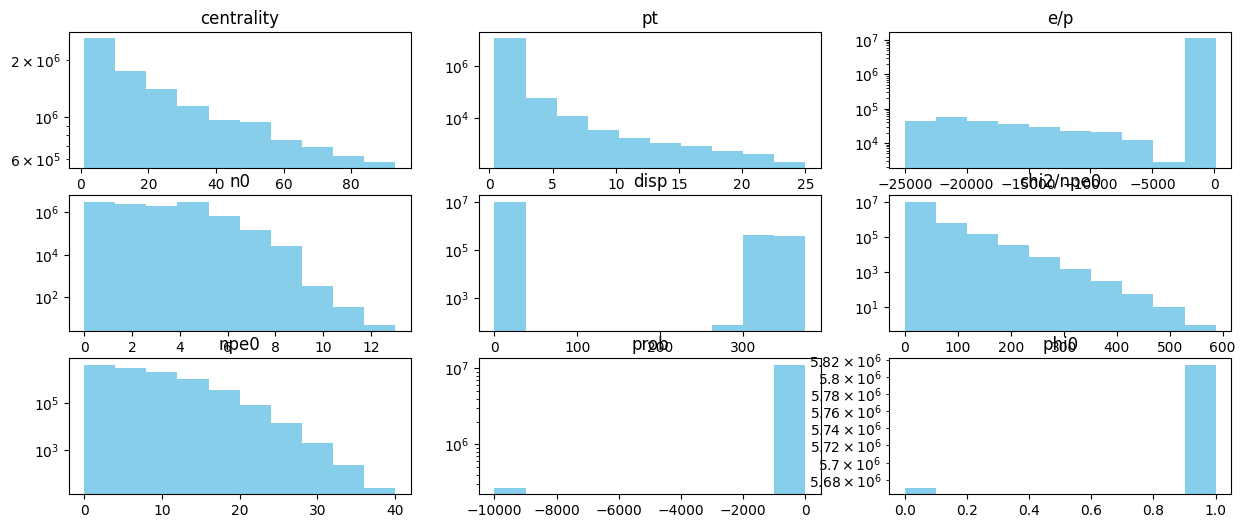

In [10]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [11]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)
    kek_data = data[cut_off_test:]
    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val, kek_data

In [12]:
X_train_all, X_test, y_train_all, y_test, cut_off_val, kek_data = feature_engineering(data)

3828362 7656725


In [13]:
X_test

centrality        pt       e/p  n0        disp  chi2/npe0  npe0  \
601604            1  1.724777  0.630829   1    1.748017   5.785999     1   
3449565          46  0.586761  0.976568   4    4.009896   4.348093    11   
1115469           4  0.587184  0.445196   0  352.407776  56.713310     0   
6602695           9  0.537671  0.803592   2    6.497015   9.393820     4   
3670104          13  0.886558  0.876201   2    5.261444   3.904435     5   
...             ...       ...       ...  ..         ...        ...   ...   
3927959          15  2.281218  0.062024   1    7.936976  43.151075     2   
935893           71  1.444249  0.605477   6    0.803788   2.035162    13   
7110697           2  0.643475  0.092383   4    1.184492   6.166123    13   
7377361          66  0.735490  0.871948   4    1.115009   9.757633     7   
752038           64  2.804246  1.023750   4    3.287155  19.407741     6   

             prob         disp2   centr+pt     e/p*pt      n0*pt  
601604   0.007543      0.236109   3.024856   7.899108   9.395152  
3449565  0.966964     -0.019816   2.644288   6.347044  16.155711  
1115469  0.035268 -31047.810125   0.544785   2.348735   4.150711  
6602695  0.007443     -8.552801   0.739090   4.150683   5.254460  
3670104  0.971354     -4.920698   1.435985   5.546232  17.868900  
...           ...           ...        ...        ...        ...  
3927959  0.443247    -14.748899   5.953955  10.124871  10.426628  
935893   0.230451      5.838481   5.635856  11.776998   8.689675  
7110697  0.578429      3.649245   0.514060   6.573901   4.224279  
7377361  0.287078      3.689189   3.840945   6.941958   7.082949  
752038   0.028551      1.298654  11.063798  15.216986  14.302761  

[3828361 rows x 12 columns]

In [14]:
X_train, X_val = X_train_all, X_train_all[cut_off_val:]
y_train, y_val = y_train_all, y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [15]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=2, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.49      1.00      0.66   1889709
           1       0.00      0.00      0.00   1938652

    accuracy                           0.49   3828361
   macro avg       0.25      0.50      0.33   3828361
weighted avg       0.24      0.49      0.33   3828361

confusion matrix
[[1889709       0]
 [1938652       0]]


In [16]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.6,0.5,0.3],
    "min_samples_split": [0.00005,0.0001,0.005],
    "max_depth":[10],
    "max_features":["sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=3)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.7019748137649506
{'criterion': 'squared_error', 'learning_rate': 0.6, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5e-05, 'n_estimators': 10}
0.7087749658727761
time of execution (sec) 2316.2607254981995


# Cross Validation

In [17]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77   1889709
           1       1.00      0.41      0.58   1938652

    accuracy                           0.70   3828361
   macro avg       0.81      0.71      0.68   3828361
weighted avg       0.81      0.70      0.67   3828361



In [18]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.01114843435830687
roc auc: 0.9756506653999243
f1 score: 0.9301398932513658


Text(0.5, 1.0, 'ROC AUC Curve')

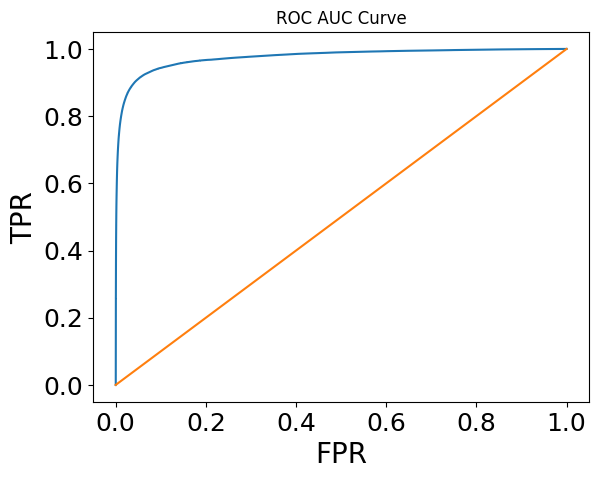

In [19]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [20]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.6930654588884636


In [140]:
i = 400000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.857 0.0266
0.006597996728539481 0.022771760096395793 0.857176017150061


In [141]:
print(sum(predicted),len(predicted))

800702 3828361


In [142]:
#kek_data = data
#kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(X_test)
print(proba_loc[0][1])

0.0011005545907141552


In [143]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 40, 0, 10, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 40, 0, 10, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 40, 0, 10, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 40, 0, 10, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 40, 0, 10, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 40, 0, 10, 10, 0, 100)

In [144]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = kek_data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>10000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2/npe0'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if ep>0.8 and n0>=2 and disp <5 and prob>0.01 and chi2<10: 
        if phi0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        #if ep<=0.5: print(ep)
        if phi0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [145]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

1938652 946744209 0.585 0.011 0.857 0.023 0.027 0.027


In [146]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

0.702 1.466 2.087 1129


In [147]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [148]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_s,"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_sd,"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

2867.0 1118.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [149]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [150]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

#print(clf.predict(X_test[0:10]))

In [151]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(X_test[0:10]))

[0 1 0 0 0 0 1 0 0 0]


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.238882 to fit



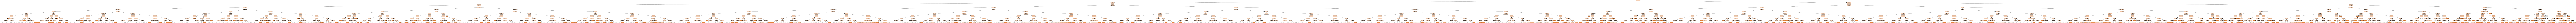

In [152]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [153]:
clf2.predict(X_test[0:100])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [154]:
clf2.predict_proba(X_test[0:100])

array([[9.98899445e-01, 1.10055459e-03],
       [4.87080100e-01, 5.12919900e-01],
       [9.99001731e-01, 9.98268717e-04],
       [9.98410273e-01, 1.58972676e-03],
       [9.92542599e-01, 7.45740150e-03],
       [9.98937742e-01, 1.06225762e-03],
       [4.69354779e-01, 5.30645221e-01],
       [9.98752533e-01, 1.24746708e-03],
       [9.62115162e-01, 3.78848385e-02],
       [9.98981546e-01, 1.01845379e-03],
       [9.36178662e-01, 6.38213376e-02],
       [9.98741341e-01, 1.25865912e-03],
       [9.98963548e-01, 1.03645224e-03],
       [9.51022562e-01, 4.89774384e-02],
       [6.33467890e-01, 3.66532110e-01],
       [9.98964488e-01, 1.03551179e-03],
       [9.93394458e-01, 6.60554166e-03],
       [6.13010336e-01, 3.86989664e-01],
       [9.98290165e-01, 1.70983477e-03],
       [9.98980958e-01, 1.01904212e-03],
       [9.98979345e-01, 1.02065506e-03],
       [9.98033314e-01, 1.96668616e-03],
       [9.04767525e-02, 9.09523248e-01],
       [3.40347284e-02, 9.65965272e-01],
       [9.987510

In [155]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.6, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5e-05, 'n_estimators': 10}


In [156]:
clf2.best_estimator_.predict_proba(X_test[9:20])

array([[0.99898155, 0.00101845],
       [0.93617866, 0.06382134],
       [0.99874134, 0.00125866],
       [0.99896355, 0.00103645],
       [0.95102256, 0.04897744],
       [0.63346789, 0.36653211],
       [0.99896449, 0.00103551],
       [0.99339446, 0.00660554],
       [0.61301034, 0.38698966],
       [0.99829017, 0.00170983],
       [0.99898096, 0.00101904]])

In [157]:
y = clf2.best_estimator_[0, 0].predict(X_test[9:19].values.tolist())*0
#y = gb_clf.decision_function(X_test[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(X_test[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(X_test[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.6
[-6.88845072 -2.68571876 -6.67644886 -6.87091471 -2.96617803 -0.54712318
 -6.87182344 -5.01321888 -0.45998381 -6.36964724]
[-6.34173903 -5.31435503 -6.01240671 -6.34173903 -5.31435503 -5.31435503
 -6.34173903 -6.01240671 -5.31435503 -6.01240671 -6.34173903]
[0.00101845 0.06382134 0.00125866 0.00103645 0.04897744 0.36653211
 0.00103551 0.00660554 0.38698966 0.00170983]


In [158]:
best_gbc = clf2.best_estimator_

In [159]:
n_estim = best_gbc.n_estimators

In [160]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(X_test[9:19]))
arr = clf2.decision_function(X_test[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(X_test[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-6.88845072 -2.68571876 -6.67644886 -6.87091471 -2.96617803 -0.54712318
 -6.87182344 -5.01321888 -0.45998381 -6.36964724]
[0.00101845 0.06382134 0.00125866 0.00103645 0.04897744 0.36653211
 0.00103551 0.00660554 0.38698966 0.00170983]
0.6


In [161]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(X_test[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(X_test[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [162]:
print(log_odds_predictions)

[[-1.999828874017743, -1.82373550456452, -1.999646513082787, -1.999828874017743, -1.1907440823691753, -1.123403626396512, -1.999828874017743, -1.957240026771678, 0.07272809558291093, -1.998585242384244], [-1.3010753650564226, -0.4552370557087722, -1.2992019012715434, -1.300892245275773, -1.1440239763137814, -0.4501057998176155, -1.300892245275773, -1.2992019012715434, 0.37426744647101007, -1.2992019012715434], [-1.137777087650898, -0.7796390056054002, -1.1341301958113905, -1.137544553817965, -0.5576839265115463, 0.11436327834947357, -1.137544553817965, -1.0959436067569912, -0.6127190921378717, -1.1349954331120975], [-1.0676703206109575, -0.6686677972822958, -1.0676703206109575, -1.0676703206109575, 0.29588776154515634, -0.6845635396327886, -1.0691848663797472, -1.0437663671078024, 0.28058424542605437, -1.0649835389549542], [-1.0337238075874757, 0.1180866247243767, -1.0110663516332696, -1.0337238075874757, -0.9829891170835887, 0.020062923692284143, -1.0337238075874757, -1.00331588832064

In [163]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(X_test[9:19]))

0.6 -6.888450722176956
[-6.88845072 -2.68571876 -6.67644886 -6.87091471 -2.96617803 -0.54712318
 -6.87182344 -5.01321888 -0.45998381 -6.36964724]


In [164]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(X_test[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

10
1
[[-1.999828874017743, -1.3010753650564226, -1.137777087650898, -1.0676703206109575, -1.0337238075874757, -1.0173939616529737, -0.9991848497374592, -1.0012624046897625, -0.9770976249266845, -0.9457369076978812], [-1.82373550456452, -0.4552370557087722, -0.7796390056054002, -0.6686677972822958, 0.1180866247243767, -0.6004740299029772, 0.040519793309711595, -0.3592836689032434, 0.1493534252218865, -0.09712070924659127], [-1.999646513082787, -1.2992019012715434, -1.1341301958113905, -1.0676703206109575, -1.0110663516332696, -1.0079032498983578, -0.9991848497374592, -0.9243455007193894, -0.7366555540541017, -0.9476103322812194], [-1.999828874017743, -1.300892245275773, -1.137544553817965, -1.0676703206109575, -1.0337238075874757, -1.013758686792118, -0.9991848497374592, -0.9891803574270258, -0.9640039199109433, -0.9457369076978812], [-1.1907440823691753, -1.1440239763137814, -0.5576839265115463, 0.29588776154515634, -0.9829891170835887, -0.6004740299029772, -0.04079116017800277, -0.389

In [165]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [166]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [167]:
#print(f"double mytree{list(X_test.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[3] <= 4.5) if (x[2] <= 0.82675) if (x[2] <= 0.75903) if (x[6] <= 6.5) if (x[7] > -4999.5) if (x[2] <= 0.68715) if (x[8] <= -0.17656) if (x[8] <= -3.99535) if (x[9] <= 624.29263) if (x[2] > 0.11652)   return -1.9998288740177428;  // | based on 1,777,156 samples
        if  (x[3] <= 4.5) if (x[2] <= 0.82675) if (x[2] <= 0.75903) if (x[6] <= 6.5) if (x[7] > -4999.5) if (x[2] <= 0.68715) if (x[8] <= -0.17656) if (x[8] > -3.99535) if (x[0] <= 61.5) if (x[8] > -3.99535)   return -1.9995795727984877;  // | based on 361,808 samples
        if  (x[3] <= 4.5) if (x[2] <= 0.82675) if (x[2] <= 0.75903) if (x[6] <= 6.5) if (x[7] > -4999.5) if (x[2] <= 0.68715) if (x[8] <= -0.17656) if (x[8] <= -3.99535) if (x[9] <= 624.29263) if (x[2] <= 0.11652)   return -1.9993457051803682;  // | based on 236,157 samples
        if  (x[3] > 4.5) if (x[11] <= 12.87343) if (x[2] > 0.80629) if (x[9] > 2.98271) if (x[2] <= 1.14343) if (x[4] <= 2.89699) if (x[6] > 9.5) if (x

In [168]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [169]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[3] <= 4.5) and (x[2] <= 0.82675) and (x[2] <= 0.75903) and (x[6] <= 6.5) and (x[7] > -4999.5) and (x[2] <= 0.68715) and (x[8] <= -0.17656) and (x[8] <= -3.99535) and (x[9] <= 624.29263) and (x[2] > 0.11652) :  return -1.9998288740177428  # | based on 1,777,156 samples
        if (x[3] <= 4.5) and (x[2] <= 0.82675) and (x[2] <= 0.75903) and (x[6] <= 6.5) and (x[7] > -4999.5) and (x[2] <= 0.68715) and (x[8] <= -0.17656) and (x[8] > -3.99535) and (x[0] <= 61.5) and (x[8] > -3.99535) :  return -1.9995795727984877  # | based on 361,808 samples
        if (x[3] <= 4.5) and (x[2] <= 0.82675) and (x[2] <= 0.75903) and (x[6] <= 6.5) and (x[7] > -4999.5) and (x[2] <= 0.68715) and (x[8] <= -0.17656) and (x[8] <= -3.99535) and (x[9] <= 624.29263) and (x[2] <= 0.11652) :  return -1.9993457051803682  # | based on 236,157 samples
        if (x[3] > 4.5) and (x[11] <= 12.87343) and (x[2] > 0.80629) and (x[9] > 2.98271) and (x[2] <= 1.14343) 

In [170]:
def mytree(x,y):
    return 0

In [171]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [172]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [173]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(X_test[9:19].values.tolist())
print(y)

myf = [mytree(iestim, X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.94573691 -0.09712071 -0.94761033 -0.94573691 -0.09712071 -0.09712071
 -0.94573691  0.38861783 -0.09712071 -0.70286348]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [174]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.99898155 0.00101845]
 [0.93617866 0.06382134]
 [0.99874134 0.00125866]
 [0.99896355 0.00103645]
 [0.95102256 0.04897744]
 [0.63346789 0.36653211]
 [0.99896449 0.00103551]
 [0.99339446 0.00660554]
 [0.61301034 0.38698966]
 [0.99829017 0.00170983]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [175]:
input_x = [ X_test[9:19].values.tolist()[0][i] for i in range(len(X_test[9:19].values.tolist()[0])) ]
print(input_x)

[16.0, 0.4859776496887207, 0.5762702642482833, 0.0, 339.7643737792969, 123.81045532226562, 0.0, 0.0185681674629449, -28859.95742240944, 1.036174275996973, 1.9439105987548828, 4.232694868954704]


In [176]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
y = [y[i][1] for i in range(len(y))]
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[0.0010184537890094232, 0.06382133763243535, 0.0012586591222510557, 0.0010364522419096887, 0.04897743841702166, 0.3665321097853009, 0.001035511791965718, 0.006605541656648035, 0.38698966409333413, 0.0017098347664460673]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [177]:
column_headers = list(X_test.columns.values)
print(column_headers)
print(len(column_headers))

['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'npe0', 'prob', 'disp2', 'centr+pt', 'e/p*pt', 'n0*pt']
12
